In [3]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/alzheimer-dataset/train_new_augmented/train_new_augmented/Final AD JPEG/Final AD JPEG_0_7083.jpg
/kaggle/input/alzheimer-dataset/train_new_augmented/train_new_augmented/Final AD JPEG/Final AD JPEG_0_5229.jpg
/kaggle/input/alzheimer-dataset/train_new_augmented/train_new_augmented/Final AD JPEG/Final AD JPEG_0_7680.jpg
/kaggle/input/alzheimer-dataset/train_new_augmented/train_new_augmented/Final AD JPEG/Final AD JPEG_0_9500.jpg
/kaggle/input/alzheimer-dataset/train_new_augmented/train_new_augmented/Final AD JPEG/Final AD JPEG_0_959.jpg
/kaggle/input/alzheimer-dataset/train_new_augmented/train_new_augmented/Final AD JPEG/Final AD JPEG_0_4461.jpg
/kaggle/input/alzheimer-dataset/train_new_augmented/train_new_augmented/Final AD JPEG/Final AD JPEG_0_176.jpg
/kaggle/input/alzheimer-dataset/train_new_augmented/train_new_augmented/Final AD JPEG/Final AD JPEG_0_524.jpg
/kaggle/input/alzheimer-dataset/train_new_augmented/train_new_augmented/Final AD JPEG/Final AD JPEG_0_6333.jpg
/kag

In [4]:
import matplotlib.pyplot as plt
import numpy as np
import os 
from tqdm import tqdm 
import seaborn as sns 
import cv2
import io
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
from tensorflow.keras.applications import EfficientNetB7
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, TensorBoard, ModelCheckpoint
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from tensorflow.keras.utils import to_categorical
from warnings import filterwarnings
from PIL import Image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from IPython.display import display, clear_output


2024-04-20 18:02:44.160424: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-04-20 18:02:44.160528: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-04-20 18:02:44.290440: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [5]:
train_path="/kaggle/input/alzheimer-dataset/train_new_augmented/train_new_augmented"
print("List of Classes:", os.listdir(train_path))

List of Classes: ['Final AD JPEG', 'Final LMCI JPEG', 'Final MCI JPEG', 'Final CN JPEG', 'Final EMCI JPEG']


In [6]:
test_path="/kaggle/input/alzheimer-dataset/test/test"
print("List of Classes:", os.listdir(test_path))

List of Classes: ['Final AD JPEG', 'Final LMCI JPEG', 'Final MCI JPEG', 'Final CN JPEG', 'Final EMCI JPEG']


In [7]:
labels =['Final AD JPEG', 'Final LMCI JPEG', 'Final MCI JPEG', 'Final CN JPEG', 'Final EMCI JPEG']

In [8]:
X_train=[]
y_train=[]

image_size=162
for i in labels:
    folderDirectory = os.path.join("/kaggle/input/alzheimer-dataset/train_new_augmented/train_new_augmented", i) #tagging labels by i
    for j in tqdm(os.listdir(folderDirectory)): #tqdm counting
        image=cv2.imread(os.path.join(folderDirectory, j)) #image to array
        image=cv2.resize(image, (image_size, image_size))

        X_train.append(image)
        y_train.append(i)
for i in labels:
    folderDirectory=os.path.join("/kaggle/input/alzheimer-dataset/test/test", i)
    for j in tqdm(os.listdir(folderDirectory)):
        image=cv2.imread(os.path.join(folderDirectory, j))
        image=cv2.resize(image, (image_size,image_size))

        X_train.append(image)
        y_train.append(i)
X_train=np.array(X_train)
y_train = np.array(y_train)

100%|██████████| 36/36 [00:00<00:00, 266.83it/s]


In [9]:
print("X_train Shape:", X_train.shape)
print("y_train Shape:", y_train.shape)

X_train Shape: (5750, 162, 162, 3)
y_train Shape: (5750,)


In [10]:
_,y_trainImageInfo= np.unique(y_train, return_counts =True)
print("Final AD JPEG:")
print("counts:", y_trainImageInfo[0])
print("Final CN JPEG:")
print("counts:", y_trainImageInfo[1])
print("Final EMCI JPEG:")
print("counts:", y_trainImageInfo[2])
print("Final LMCI JPEG:")
print("counts:", y_trainImageInfo[3])
print("Final MCI JPEG:")
print("counts:", y_trainImageInfo[4])

Final AD JPEG:
counts: 1202
Final CN JPEG:
counts: 1311
Final EMCI JPEG:
counts: 1275
Final LMCI JPEG:
counts: 708
Final MCI JPEG:
counts: 1254


In [11]:
#shuffle based on randomState
X_train, y_train = shuffle(X_train, y_train, random_state=101)

In [12]:
print(y_train[0])
print(y_train[1000])
print(y_train[2000])
print(y_train[3500])
print(y_train[4050])

Final LMCI JPEG
Final CN JPEG
Final AD JPEG
Final MCI JPEG
Final AD JPEG


In [13]:
X_train, X_test, y_train, y_test =train_test_split(X_train, y_train, test_size=0.25, random_state=101)

In [14]:
y_train_new=[]
y_test_new=[]

for i in y_train:
    y_train_new.append(labels.index(i)) #indexing value of y_train
y_train = y_train_new
y_train = to_categorical(y_train)

for i in y_test:
    y_test_new.append(labels.index(i))
y_test = y_test_new
y_test = to_categorical(y_test)

In [15]:
efficient = EfficientNetB7(weights ="imagenet", include_top=False, input_shape=(image_size, image_size, 3))

258076736/258076736 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


In [18]:
import tensorflow as tf
#pooling can be avg or max
#dropout range 0.3 -0.5 which means 30-50% neurons will be dropped to avoid overfitting
model=efficient.output
model=tf.keras.layers.GlobalMaxPooling2D()(model)
model=tf.keras.layers.Dropout(0.6)(model)
model=tf.keras.layers.Dense(5, activation="softmax")(model)
model=tf.keras.models.Model(inputs=efficient.input, outputs=model)

In [19]:
#loss for categorical value, adam perform best
model.compile(loss="categorical_crossentropy",
              optimizer="adam",
              metrics =["accuracy"])

# .h5 = Hierarchical Data Format Ver. 5 file, verbose =1, to see execution
tensorboard = TensorBoard(log_dir="logs")
checkpoint = ModelCheckpoint(
    "efficient.keras",
    monitor="val_accuracy",
    verbose=1,
    mode="auto",
    save_best_only=True,
)
# monitor: quantity to be monitored.
# factor: factor by which the learning rate will be reduced.
# patience: number of epochs with no improvement after which learning rate will be reduced.
# verbose: int. 0: quiet, 1: update messages.
# min_delta: early stopping of epochs
reduce_lr = ReduceLROnPlateau(
    monitor="val_accuracy",
    factor=0.5,
    patience=3,
    verbose=1,
    mode="auto",
    min_delta=0.001,
)

In [20]:
history = model.fit(X_train, y_train,
                   validation_split=0.25,
                   epochs=10, verbose=1,
                   batch_size=32,
                   callbacks =[tensorboard, checkpoint, reduce_lr])

Epoch 1/10


I0000 00:00:1713636607.636107      87 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.
W0000 00:00:1713636608.004969      87 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


102/102 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.2503 - loss: 3.1754   

W0000 00:00:1713636866.347147      86 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update



Epoch 1: val_accuracy improved from -inf to 0.33952, saving model to efficient.keras
102/102 ━━━━━━━━━━━━━━━━━━━━ 645s 3s/step - accuracy: 0.2505 - loss: 3.1655 - val_accuracy: 0.3395 - val_loss: 1.5272 - learning_rate: 0.0010
Epoch 2/10
102/102 ━━━━━━━━━━━━━━━━━━━━ 0s 443ms/step - accuracy: 0.3765 - loss: 1.4398
Epoch 2: val_accuracy improved from 0.33952 to 0.38312, saving model to efficient.keras
102/102 ━━━━━━━━━━━━━━━━━━━━ 54s 534ms/step - accuracy: 0.3766 - loss: 1.4396 - val_accuracy: 0.3831 - val_loss: 1.4004 - learning_rate: 0.0010
Epoch 3/10
102/102 ━━━━━━━━━━━━━━━━━━━━ 0s 443ms/step - accuracy: 0.5134 - loss: 1.1983
Epoch 3: val_accuracy did not improve from 0.38312
102/102 ━━━━━━━━━━━━━━━━━━━━ 49s 477ms/step - accuracy: 0.5134 - loss: 1.1985 - val_accuracy: 0.3571 - val_loss: 1.8379 - learning_rate: 0.0010
Epoch 4/10
102/102 ━━━━━━━━━━━━━━━━━━━━ 0s 442ms/step - accuracy: 0.6026 - loss: 1.0523
Epoch 4: val_accuracy improved from 0.38312 to 0.43599, saving model to efficient

In [21]:
model.save('model.h5')

In [ ]:
import tensorflow as tf

# Load the model
model = tf.keras.models.load_model('model.h5')

In [23]:
def accuracy_lr_loss_plot (history):
    fig = plt.figure(figsize=(15,10))

    plt.subplot(231)
    plt.plot(history.history["accuracy"], 'bo--', label="accuracy")
    plt.plot(history.history['val_accuracy'], 'ro--', label="val_accuracy")
    plt.title("Training Data Accuracy Measurements")
    plt.xlabel("Number of epochs")
    plt.ylabel("Accuracy")
    plt.grid()
    plt.legend()
    plt.tight_layout()

    plt.subplot(232)
    plt.plot(history.history['learning_rate'], 'go--', label="Learning Rate")
    plt.title("Learning Rate")
    plt.xlabel("Number of epochs")
    plt.ylabel("Learning Rate")
    plt.grid()
    plt.legend()
    plt.tight_layout()


    plt.subplot(233)
    plt.plot(history.history["loss"], "bo--", label="loss")
    plt.plot(history.history["val_loss"], "ro--", label = "val_loss")
    plt.title("Training Data Loss")
    plt.xlabel("Number of epochs")
    plt.ylabel("loss")
    plt.grid()
    plt.legend()
    plt.tight_layout()

    plt.show()

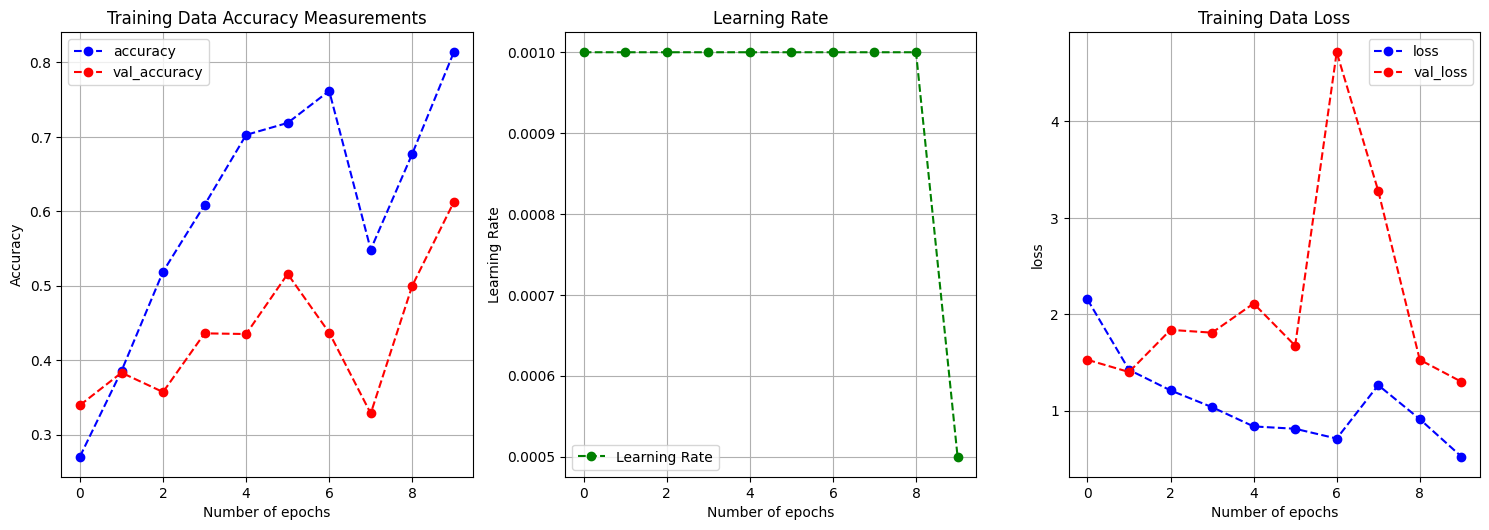

In [25]:
accuracy_lr_loss_plot(history)

In [24]:
X_testloss=model.evaluate(X_test, y_test, verbose=1)

45/45 ━━━━━━━━━━━━━━━━━━━━ 18s 407ms/step - accuracy: 0.6119 - loss: 1.2276


W0000 00:00:1713637406.029303      88 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


In [26]:
y_pred = model.predict(X_test)
y_pred=np.argmax(y_pred, axis=1)
y_test_new = np.argmax(y_test, axis=1)

45/45 ━━━━━━━━━━━━━━━━━━━━ 36s 466ms/step


In [28]:
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
print(classification_report(y_test_new, y_pred))

              precision    recall  f1-score   support

           0       0.77      0.64      0.70       295
           1       0.80      0.60      0.69       184
           2       0.59      0.59      0.59       309
           3       0.50      0.66      0.57       314
           4       0.61      0.60      0.60       336

    accuracy                           0.62      1438
   macro avg       0.65      0.62      0.63      1438
weighted avg       0.64      0.62      0.62      1438



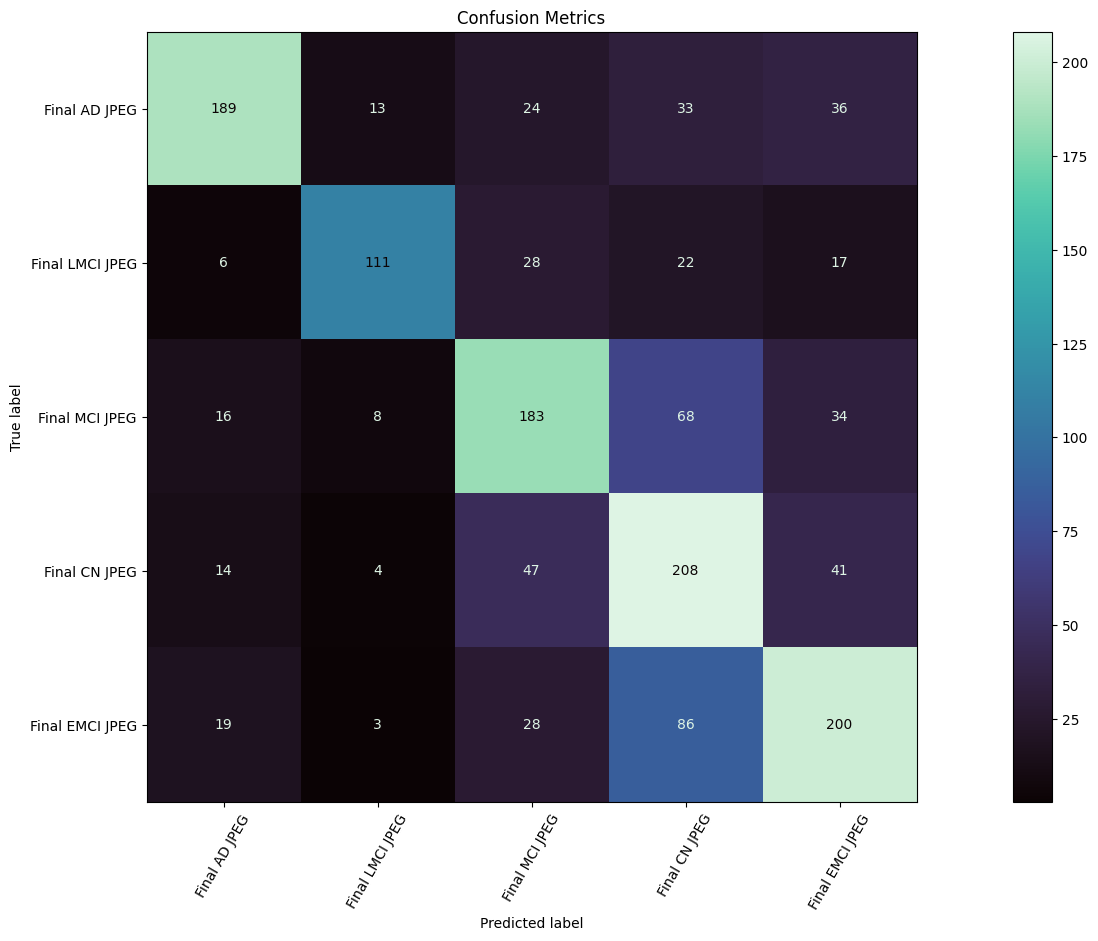

In [29]:
    cm=confusion_matrix(y_test_new, y_pred)
    display_c_m = ConfusionMatrixDisplay(cm, display_labels=labels)
    fig, ax = plt.subplots(figsize=(25,10))
    display_c_m.plot(cmap='mako',ax=ax,xticks_rotation=60)
    plt.title("Confusion Metrics")
    plt.show()

In [30]:
from sklearn.metrics import confusion_matrix

# Assuming you have already defined your confusion matrix 'cm'

# Extracting values from the confusion matrix
TP = np.diag(cm)  # True Positives
total = cm.sum()  # Total predictions

# Calculating accuracy
accuracy = TP.sum() / total

print("Accuracy:", accuracy)

Accuracy: 0.6196105702364395
